In [22]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import numpy as np

# Load Files and Consistency Checks

In [23]:
def read_algorithm_results(problem, file):
    if problem in "3SAT":
        num_samples = 400
        num_alpha_values = 21
    elif problem == "4SAT":
        num_samples = 200
        num_alpha_values = 21
    elif problem == "3COL":
        num_samples = 400
        num_alpha_values = 10
    elif problem == "5COL":
        num_samples = 400
        num_alpha_values = 10
    # require E column to be an integer
    # df = pd.read_csv(file, dtype={"E": int}
    df = pd.read_csv(file)
    assert df.E.dtype == "int64"
    assert (df.columns[:4] == ["N", "M", "id", "E"]).all()
    # check that for each N, M, 
    # - the number of instances is equal to 400
    # - the ids are unique
    # - the ids are in the range [1, 400]
    # - the energy is a non-negative integer
    # - the number of M values for each N is 21
    for (n, m), group in df.groupby(["N", "M"]):
        # assert len(group) == num_samples
        if len(group) != num_samples:
            print(f"Warning: n={n}, m={m}, shape={group.shape}")
            correct_num_samples = False
        else:
            correct_num_samples = True
        assert group["id"].is_unique
        if correct_num_samples:
            assert group["id"].min() == 1
            assert group["id"].max() == num_samples
        assert (group["E"] >= 0).all()
        
    for n, group in df.groupby("N"):
        alphas = np.sort(np.unique(group.M / group.N))
        if len(alphas) != num_alpha_values:
            print(f"Warning: n={n}, num_alpha_values = {len(alphas)} != {num_alpha_values}")
        else:
            if problem == "3COL":
                assert np.abs((alphas - np.arange(3.32, 5.0, 0.18)/2)).max() < 0.05
            elif problem == "5COL":
                assert np.abs((alphas == np.arange(9.9, 13.6, 0.4)/2)).max() < 0.05  
            elif problem == "3SAT":
                assert np.abs((alphas - np.arange(3.0, 5.01, 0.1))).max() < 0.03
            elif problem == "5SAT":
                assert np.abs((alphas - np.arange(8.0, 10.01, 0.1))).max() < 0.03
            
    result_df = df.groupby(["N", "M"]).agg(
        count=("id", "count"),
        E_mean=("E", "mean"),
        E_err=("E", lambda x: x.std() / (len(x) ** 0.5)),
        ProbSolv=("E", lambda x: (x == 0).mean()),
        ProbSolv_err=("E", lambda x: (x == 0).std() / (len(x) ** 0.5)),
        # compute the mean energy only for the instances that are not solved
        # E_mean_unsolved=("E", lambda x: x[x > 0].mean() if len(x[x > 0]) > 0 else 0),
        # E_err_unsolved=("E", lambda x:  (x[x > 0].std() / (len(x[x > 0]) ** 0.5)) if len(x[x>0]) > 0 else -1),
    ).reset_index()
    # Insert "algo" column as the first column
    result_df.insert(0, "algo", file.split(f"{problem}_")[1][:-4])
    
    slim_df = df[["N", "M", "id", "E"]]
    return result_df, slim_df

def check_consistency_among_algos(df):
    algos = df["algo"].unique()
    Ns = df["N"].unique()
    for N in Ns:
        Ma = None
        for i, b in enumerate(algos):
            Mb = df[(df["N"] == N) & (df["algo"] == b)]["M"].values
            if Ma is None and len(Mb) > 0:
                Ma = Mb
            # check that the M values are the same as the ones in the first algo
            if len(Mb) > 0:
                assert (Ma == Mb).all()

In [24]:
for problem in ("3SAT", "4SAT", "3COL", "5COL"):
    files = glob(f"{problem}/*.csv")
    df = pd.DataFrame()
    dict_best = {}
    for file in files:
        print(file)
        result_df, slim_df = read_algorithm_results(problem, file)
        df = pd.concat([df, result_df], ignore_index=True)
        for (N, M, idx, E) in zip(slim_df.N, slim_df.M, slim_df["id"], slim_df.E):
            if (N, M, idx) not in dict_best:
                dict_best[(N, M, idx)] = E
            else:
                dict_best[(N, M, idx)] = min(dict_best[(N, M, idx)], E)

    # check_consistency_among_algos(df)


    # Convert to DataFrame
    best_df = pd.DataFrame(
        [(N, M, id, E) for (N, M, id), E in dict_best.items()],
        columns=["N", "M", "id", "E"]
    )
    best_df["solved"] = (best_df["E"] == 0).astype(int)

    df.to_csv(f"analysis-results/{problem}-summary.csv", index=False)
    best_df.to_csv(f"analysis-results/{problem}-best_per_sample.csv", index=False)
    

3SAT/3SAT_FMS_nsteps=1000N^2.csv
3SAT/3SAT_NeuroSAT_unsupervised_niters=512_Ntrain=256.csv
3SAT/3SAT_FMS_nsteps=20N^2.csv
3SAT/3SAT_NeuroSAT_supervised_niters=32_Ntrain=256.csv
3SAT/3SAT_FMS_nsteps=100N^2.csv
3SAT/3SAT_NeuroSAT_unsupervised_niters=2N_Ntrain=256.csv
3SAT/3SAT_NeuroSAT_supervised_niters=512_Ntrain=256.csv
3SAT/3SAT_QuerySAT_niters=2N_Ntrain=256.csv
3SAT/3SAT_NeuroSAT_supervised_niters=2N_Ntrain=256.csv
3SAT/3SAT_SurveyPropagation_frac-decimated=0.00125.csv
3SAT/3SAT_SimulatedAnnealing_nsteps=1000N^2.csv
3SAT/3SAT_NeuroSAT_unsupervised_niters=32_Ntrain=256.csv
4SAT/4SAT_SimulatedAnnealing_nsteps=10000N^2.csv
4SAT/4SAT_FMS_nsteps=1000N^2.csv
4SAT/4SAT_FMS_nsteps=20N^2.csv
4SAT/4SAT_SimulatedAnnealing_nsteps=1000N^2 .csv
4SAT/4SAT_NeuroSAT_unsupervised_niters=2N_Ntrain=256.csv
4SAT/4SAT_QuerySAT_niters=2N_Ntrain=256.csv
4SAT/4SAT_SurveyPropagation_frac-decimated=0.00125.csv
4SAT/4SAT_FMS_nsteps=100N^2.csv
3COL/3COL_SimulatedAnnealing_nsteps=10N^2.csv
3COL/3COL_rPI-GNN_ntria

# Overview Tables

In [25]:
problems = ["3SAT", "4SAT", "3COL", "5COL"]
df = pd.DataFrame()
for problem in problems:
    dfnew = pd.read_csv(f"analysis-results/{problem}-summary.csv", dtype={"count": int})
    dfnew["problem"] = problem
    df = pd.concat([df, dfnew], ignore_index=True)
    
# sort by problem, algo, N, M
df.sort_values(["problem", "algo", "N", "M"], inplace=True)
df.reset_index(drop=True, inplace=True)
df = df[["problem", "algo", "N", "M", "count", "E_mean", 
         "E_err", "ProbSolv", "ProbSolv_err"]]

# order as 3SAT, 4SAT, 3COL, 5COL
dfoverview = pd.concat([df[df.problem == "3SAT"], df[df.problem == "4SAT"],\
          df[df.problem == "3COL"], df[df.problem == "5COL"]], ignore_index=True)

dfoverview

,problem,algo,N,M,count,E_mean,E_err,ProbSolv,ProbSolv_err
0,3SAT,FMS_nsteps=1000N^2,16,48,400,0.0000,0.000000,1.0000,0.000000
1,3SAT,FMS_nsteps=1000N^2,16,50,400,0.0050,0.003531,0.9950,0.003531
2,3SAT,FMS_nsteps=1000N^2,16,51,400,0.0100,0.004981,0.9900,0.004981
3,3SAT,FMS_nsteps=1000N^2,16,53,400,0.0025,0.002500,0.9975,0.002500
4,3SAT,FMS_nsteps=1000N^2,16,54,400,0.0125,0.005562,0.9875,0.005562
...,...,...,...,...,...,...,...,...,...
4630,5COL,rPI-GNN_ntrials=5,4096,21914,400,0.0000,0.000000,1.0000,0.000000
4631,5COL,rPI-GNN_ntrials=5,4096,22733,400,0.0000,0.000000,1.0000,0.000000
4632,5COL,rPI-GNN_ntrials=5,4096,23552,400,1.5775,0.088485,0.3250,0.023448
4633,5COL,rPI-GNN_ntrials=5,4096,24371,400,10.9225,0.175551,0.0000,0.000000


In [26]:
# for each problem, algo, N, compute the sum of the count
dfcount = dfoverview.groupby(["problem", "algo", "N"]).agg(
            count=("count", "sum"),
        ).reset_index().sort_values(["problem", "algo", "N"])

# use the N values has columns names 
dfcount = dfcount.pivot(index=["problem", "algo"], columns="N", values="count").reset_index()
dfcount.columns.name = None
dfcount = dfcount.rename_axis(None, axis=1)
# replace NaN with 0
dfcount = dfcount.fillna(0)
dfcount = dfcount.rename(columns={col: f"N={col}" for col in dfcount.columns if isinstance(col, int)})
# convert to int
for col in dfcount.columns[2:]:
    dfcount[col] = dfcount[col].astype(int)
    

# order as 3SAT, 4SAT, 3COL, 5COL
dfcount = pd.concat([dfcount[dfcount.problem == "3SAT"], dfcount[dfcount.problem == "4SAT"],\
          dfcount[dfcount.problem == "3COL"], dfcount[dfcount.problem == "5COL"]], ignore_index=True)

dfcount.to_csv(f"analysis-results/count.csv", index=False)
dfcount



,problem,algo,N=16,N=32,N=64,N=128,N=256,N=512,N=1024,N=2048,N=4096,N=8192,N=16384
0,3SAT,FMS_nsteps=1000N^2,8400,8400,8400,8400,8400,8400,8400,0,0,0,0
1,3SAT,FMS_nsteps=100N^2,8400,8400,8400,8400,8400,8400,8400,8400,0,0,0
2,3SAT,FMS_nsteps=20N^2,0,0,0,0,0,0,0,0,8400,8400,8400
3,3SAT,NeuroSAT_supervised_niters=2N_Ntrain=256,8400,8400,8400,8400,8400,0,0,0,0,0,0
4,3SAT,NeuroSAT_supervised_niters=32_Ntrain=256,8400,8400,8400,8400,8400,0,0,0,0,0,0
5,3SAT,NeuroSAT_supervised_niters=512_Ntrain=256,8400,8400,8400,8400,8400,8400,8400,8400,8400,8400,8400
6,3SAT,NeuroSAT_unsupervised_niters=2N_Ntrain=256,8400,8400,8400,8400,8400,8400,8400,8400,8400,8400,0
7,3SAT,NeuroSAT_unsupervised_niters=32_Ntrain=256,8400,8400,8400,8400,8400,0,0,0,0,0,0
8,3SAT,NeuroSAT_unsupervised_niters=512_Ntrain=256,8400,8400,8400,8400,8400,8400,8400,8400,8400,8400,8400
9,3SAT,QuerySAT_niters=2N_Ntrain=256,8400,8400,8400,8400,8400,8400,8400,8400,0,0,0


# Plot Best per Sample

In [27]:
dfbest = pd.DataFrame()
for problem in ["3SAT", "4SAT", "3COL", "5COL"]:
    dfnew = pd.read_csv(f"analysis-results/{problem}-best_per_sample.csv", dtype={"E": int})
    dfnew["problem"] = problem
    dfbest = pd.concat([dfbest, dfnew], ignore_index=True)
    
dfsummary = dfbest.groupby(["problem", "N", "M"]).agg(
    count=("id", "count"),
    E_mean=("E", "mean"),
    E_err=("E", lambda x: x.std() / (len(x) ** 0.5)),
    ProbSolv=("solved", "mean"),
    ProbSolv_err=("solved", lambda x: x.std() / (len(x) ** 0.5)),
).reset_index()

dfsummary.sort_values(["problem", "N", "M"], inplace=True)

In [28]:
dfsummary

,problem,N,M,count,E_mean,E_err,ProbSolv,ProbSolv_err
0,3COL,16,27,400,0.2000,0.020025,0.8000,0.020025
1,3COL,16,28,400,0.1975,0.019931,0.8025,0.019931
2,3COL,16,29,400,0.3200,0.023884,0.6850,0.023255
3,3COL,16,31,400,0.4975,0.026253,0.5150,0.025020
4,3COL,16,32,400,0.5975,0.027443,0.4325,0.024802
...,...,...,...,...,...,...,...,...
698,5COL,16384,97485,400,0.0000,0.000000,1.0000,0.000000
699,5COL,16384,100762,400,0.0000,0.000000,1.0000,0.000000
700,5COL,16384,104038,400,0.0000,0.000000,1.0000,0.000000
701,5COL,16384,107315,400,0.8750,0.060478,0.5575,0.024865


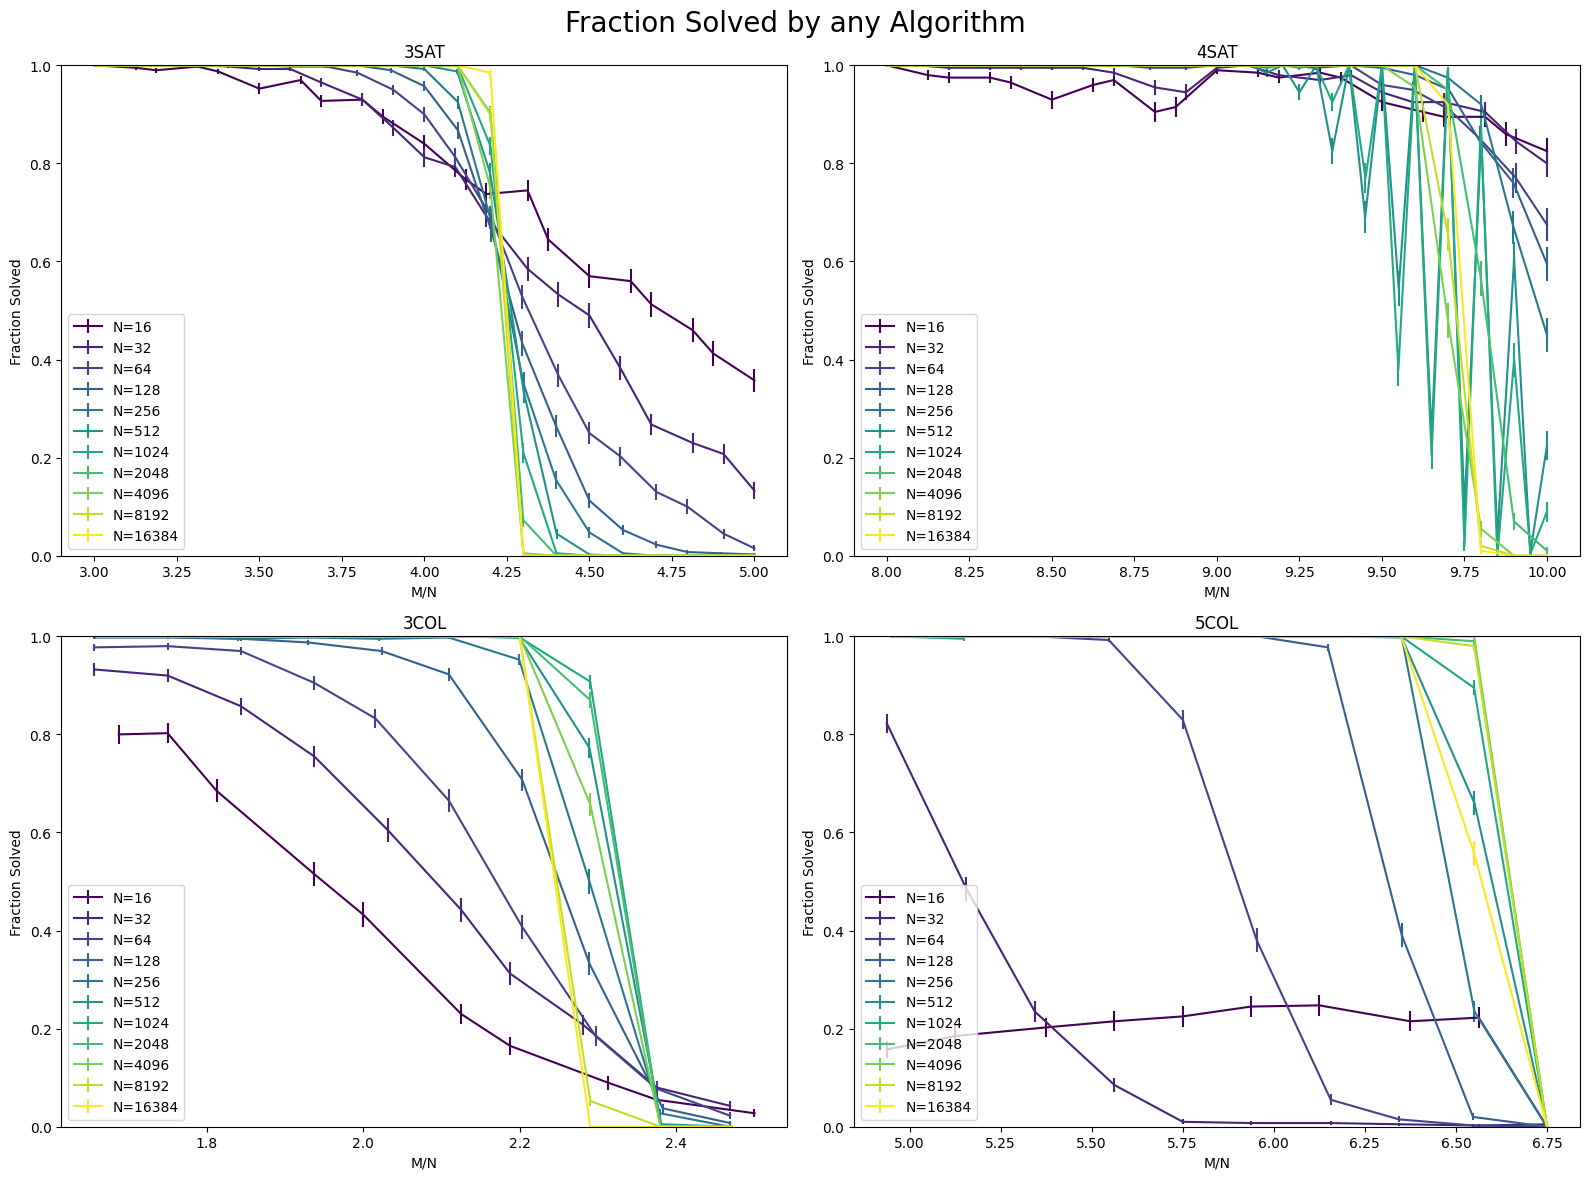

In [29]:
from matplotlib import colormaps
import numpy as np
# plot ProbSolv vs M/N for each N in 3COL with a color gradient
cmap = colormaps["viridis"]  # choose a colormap
norm = plt.Normalize(np.log(dfsummary.N.min()), np.log(dfsummary.N.max()))  # normalize N values for the colormap

fig, ax = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Fraction Solved by any Algorithm", fontsize=20)

axes = ax.flatten()  # flatten the 2x2 axes array for easier indexing
for i, problem in enumerate(["3SAT", "4SAT", "3COL", "5COL"]):
    ax = axes[i]  # select the appropriate axis for the current problem
    df = dfsummary[dfsummary.problem == problem]

    for N in df.N.unique():
        dfN = df[df.N == N]
        color = cmap(norm(np.log(N)))  # get color from colormap
        ax.errorbar(dfN.M / N, dfN.ProbSolv, yerr=dfN.ProbSolv_err, label=f"N={N}", fmt="-", color=color)

    ax.set_xlabel("M/N")
    ax.set_ylabel("Fraction Solved")
    ax.set_title(problem)
    ax.legend(loc="lower left")
    ax.set_ylim(0, 1)

# Adjust layout to make the plot tighter
fig.tight_layout()
plt.savefig("analysis-results/plot_fracsolved_best_per_sample.png", dpi=300)



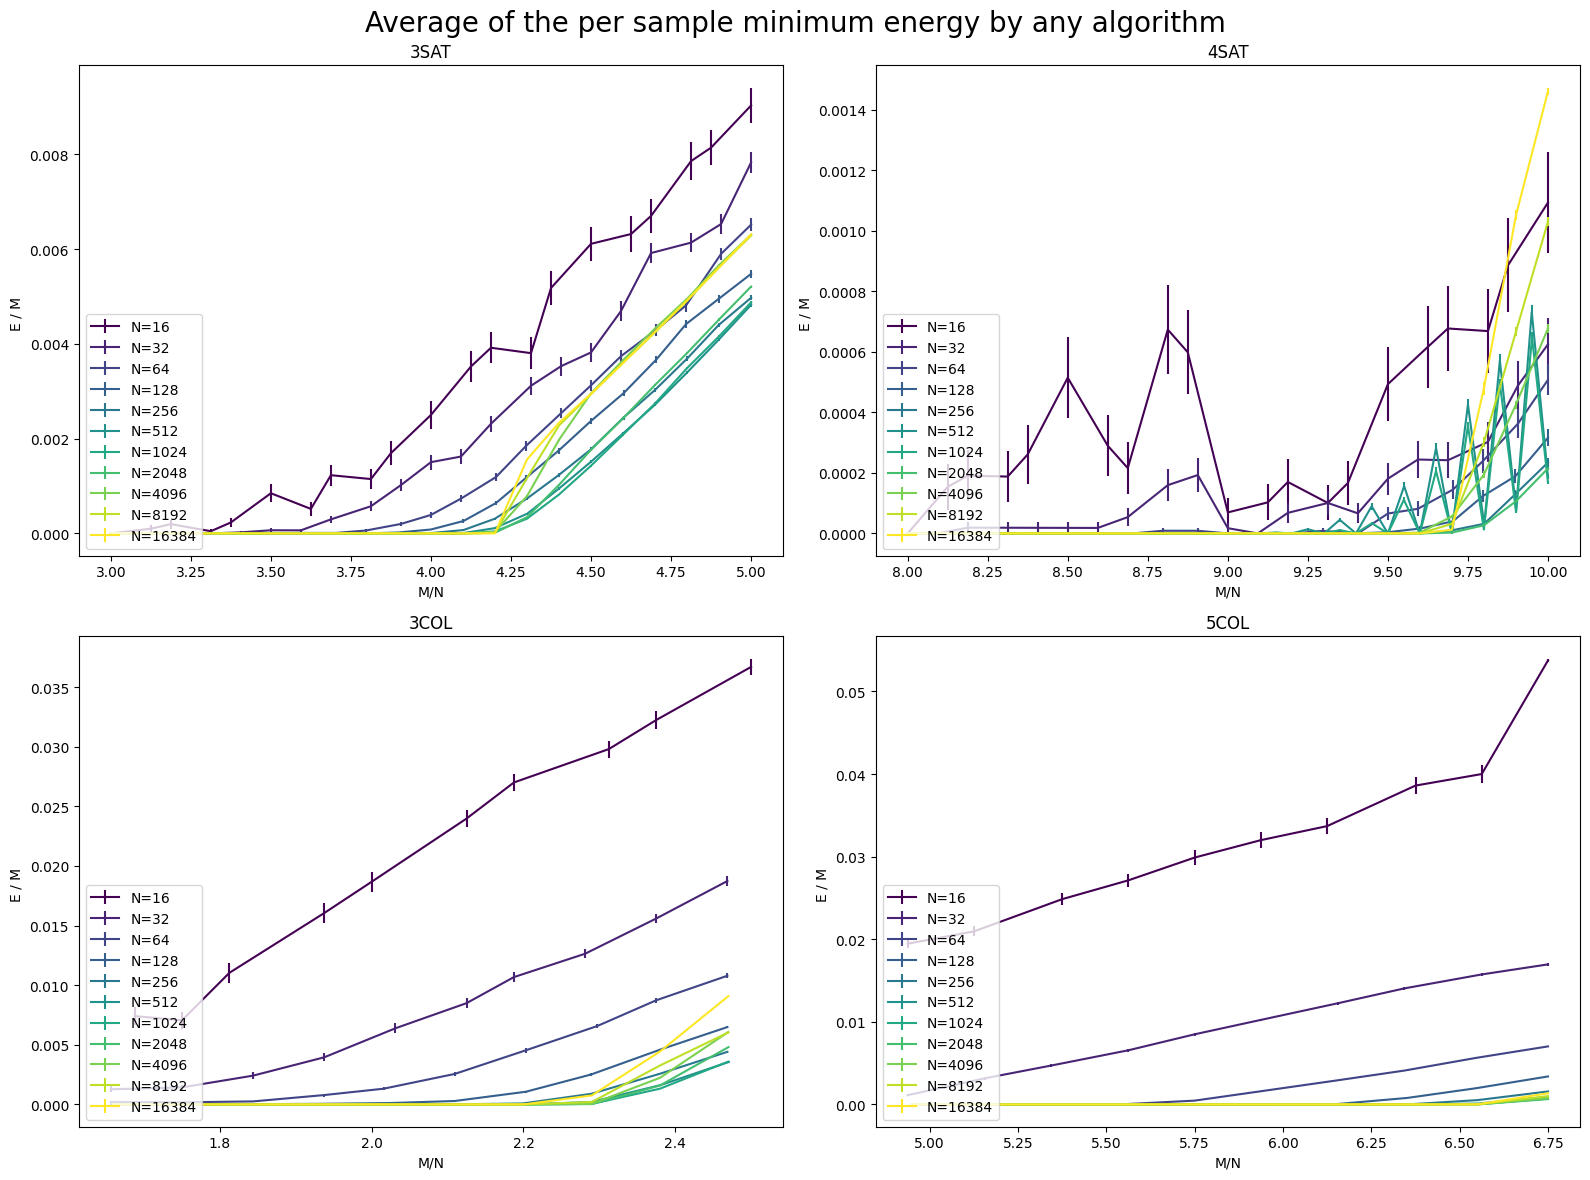

In [30]:
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Average of the per sample minimum energy by any algorithm", fontsize=20)
axes = ax.flatten()  # flatten the 2x2 axes array for easier indexing
for i, problem in enumerate(["3SAT", "4SAT", "3COL", "5COL"]):
    ax = axes[i]  # select the appropriate axis for the current problem
    df = dfsummary[dfsummary.problem == problem]

    for N in df.N.unique():
        dfN = df[df.N == N]
        color = cmap(norm(np.log(N)))  # get color from colormap
        ax.errorbar(dfN.M / N, dfN.E_mean / dfN.M, yerr=dfN.E_err / dfN.M, label=f"N={N}", fmt="-", color=color)

    ax.set_xlabel("M/N")
    ax.set_ylabel("E / M ")
    ax.set_title(problem)
    ax.legend(loc="lower left")
    # ax.set_ylim(0, 1)

# Adjust layout to make the plot tighter
fig.tight_layout()
plt.savefig("analysis-results/plot_energy_best_per_sample.png", dpi=300)

# BEST per Sample Table

In [31]:
dfbest = pd.DataFrame()
for problem in ["3SAT", "4SAT", "3COL", "5COL"]:
    dfnew = pd.read_csv(f"analysis-results/{problem}-best_per_sample.csv", dtype={"E": int})
    dfnew["problem"] = problem
    dfbest = pd.concat([dfbest, dfnew], ignore_index=True)

In [32]:
df = dfbest[dfbest.N <= 256]
dftable = df.groupby(["problem"]).agg(
    count=("id", "count"),
    nsat=("solved", "sum"),
).reset_index()
# order as 3SAT, 4SAT, 3COL, 5COL
dftable = pd.concat([dftable[dftable.problem == "3SAT"], dftable[dftable.problem == "4SAT"],\
          dftable[dftable.problem == "3COL"], dftable[dftable.problem == "5COL"]], ignore_index=True)
dftable

,problem,count,nsat
0,3SAT,42000,28656
1,4SAT,21000,20032
2,3COL,20000,11760
3,5COL,20000,9790


# Table for the Paper

For each algorithm, we consider the number of solved instances with N <= 256, and we normalize it by the number obtained in dftable

In [33]:
Nmax = 256

dfov = dfoverview[dfoverview.N <= Nmax].copy()
# as type integer
dfov["nsat"] = (dfov["ProbSolv"] * dfov["count"]).astype(int)
dfov["E_mean_frac"] = dfov.E_mean / dfov.M

df = dfov.groupby(["problem", "algo"]).agg(
    count=("count", "sum"),
    nsat=("nsat", "sum"),
    E=("E_mean_frac", "mean"),
).reset_index()
# join with dftable
df = df.merge(dftable[["problem", "count", "nsat"]], on=["problem","count"], suffixes=("", "_best"))
df["score"] = df["nsat"] / df["nsat_best"]
# multiply the score by 100 and round to 2 decimal place
df["score"] = (df["score"] * 100).round(2)

dfscore = df 
dfscore


,problem,algo,count,nsat,E,nsat_best,score
0,3COL,BeliefPropagation_frac-decimated=1overN,20000,9220,0.035123,11760,78.40
1,3COL,BeliefPropagation_reinforcement_gamma=0.99_dt=10,20000,9919,0.036401,11760,84.35
2,3COL,FMS_nsteps=1000N^2,20000,11750,0.007024,11760,99.91
3,3COL,FMS_nsteps=100N^2,20000,11732,0.007033,11760,99.76
4,3COL,FMScol_eta=0.37_nsteps=20N^2,20000,11624,0.008153,11760,98.84
5,3COL,FMScol_eta=0.37_nsteps=625N^2,20000,11745,0.008089,11760,99.87
6,3COL,SimulatedAnnealing_nsteps=1000N^2,20000,10604,0.008714,11760,90.17
7,3COL,SimulatedAnnealing_nsteps=10N^2,20000,7520,0.011403,11760,63.95
8,3COL,rPI-GNN_ntrials=5,20000,10868,0.008693,11760,92.41
9,3SAT,FMS_nsteps=1000N^2,42000,28654,0.001942,28656,99.99


In [34]:
# Compute the residual energy for the unresolved instances
df = pd.DataFrame()
for problem in ("3SAT", "4SAT", "3COL", "5COL"):
    files = glob(f"{problem}/*.csv")
    for file in files:
        print(file)
        _, slim_df = read_algorithm_results(problem, file)
        dfunsolved = slim_df[(slim_df.E>0) & (slim_df.N <= Nmax)]
        E_unsolved = (dfunsolved["E"] / dfunsolved["M"]).mean()
        algo = file.split(f"{problem}_")[1][:-4]
        dfnew = pd.DataFrame({"problem":[problem], "algo":[algo], "E_unsolved": [E_unsolved]})
        df = pd.concat([df, dfnew], ignore_index=True)
        
dfunsolved = df 
dfunsolved
        

3SAT/3SAT_FMS_nsteps=1000N^2.csv
3SAT/3SAT_NeuroSAT_unsupervised_niters=512_Ntrain=256.csv
3SAT/3SAT_FMS_nsteps=20N^2.csv
3SAT/3SAT_NeuroSAT_supervised_niters=32_Ntrain=256.csv
3SAT/3SAT_FMS_nsteps=100N^2.csv
3SAT/3SAT_NeuroSAT_unsupervised_niters=2N_Ntrain=256.csv
3SAT/3SAT_NeuroSAT_supervised_niters=512_Ntrain=256.csv
3SAT/3SAT_QuerySAT_niters=2N_Ntrain=256.csv
3SAT/3SAT_NeuroSAT_supervised_niters=2N_Ntrain=256.csv
3SAT/3SAT_SurveyPropagation_frac-decimated=0.00125.csv
3SAT/3SAT_SimulatedAnnealing_nsteps=1000N^2.csv
3SAT/3SAT_NeuroSAT_unsupervised_niters=32_Ntrain=256.csv
4SAT/4SAT_SimulatedAnnealing_nsteps=10000N^2.csv
4SAT/4SAT_FMS_nsteps=1000N^2.csv
4SAT/4SAT_FMS_nsteps=20N^2.csv
4SAT/4SAT_SimulatedAnnealing_nsteps=1000N^2 .csv
4SAT/4SAT_NeuroSAT_unsupervised_niters=2N_Ntrain=256.csv
4SAT/4SAT_QuerySAT_niters=2N_Ntrain=256.csv
4SAT/4SAT_SurveyPropagation_frac-decimated=0.00125.csv
4SAT/4SAT_FMS_nsteps=100N^2.csv
3COL/3COL_SimulatedAnnealing_nsteps=10N^2.csv
3COL/3COL_rPI-GNN_ntria

,problem,algo,E_unsolved
0,3SAT,FMS_nsteps=1000N^2,0.006113
1,3SAT,NeuroSAT_unsupervised_niters=512_Ntrain=256,0.007061
2,3SAT,FMS_nsteps=20N^2,NaN
3,3SAT,NeuroSAT_supervised_niters=32_Ntrain=256,0.021986
4,3SAT,FMS_nsteps=100N^2,0.006114
5,3SAT,NeuroSAT_unsupervised_niters=2N_Ntrain=256,0.007225
6,3SAT,NeuroSAT_supervised_niters=512_Ntrain=256,0.023739
7,3SAT,QuerySAT_niters=2N_Ntrain=256,0.006805
8,3SAT,NeuroSAT_supervised_niters=2N_Ntrain=256,0.023696
9,3SAT,SurveyPropagation_frac-decimated=0.00125,0.236426


In [35]:
# merge dfscore and dfunsolved
dfscore2 = dfscore.merge(dfunsolved, on=["problem", "algo"])
dfscore2 = dfscore2[["problem", "algo", "count", "nsat", "nsat_best", "score", "E", "E_unsolved"]]
dfscore2.to_csv("analysis-results/score.csv", index=False)